# Spanish Translation A/B Test
__- Author: Fan Yuan__  
__- Date: 03/25/2019__

## Context:
A worldwide e-commerce site with localized versions of the site want to test whther the conversion rate will be higher if the localized version is translated by a local instead of all Spanish-speaking countries using the same version of translation. After the experiment, they found that the non-localized translation was doing better.

## Project goal:
* Confirm that the test is actually negative. That is, it appears that the old version of the site with just one translation across Spain and LatAm performs better
* Explain why that might be happening. Are the localized translations really worse?
* Design an algorithm tthat would return FALSE if the same problem is happening in the future and TRUE if everything is good and the results can be trusted

## Data:
### test_table -- Columns:
* __user_id__: the id of the user. Unique by user. Can be joined to user id in the other table. For each user, we just check whether conversion happens the first time they land on the site since the test started
* __date__: when they came the the site for the first time since the test started
* __source__: marketing channel source
    + Ads: came to the site by clicking on an advertisement
    + Soe: came to the site by clicking on search results
    + Direct: came to the site by directly typing the URL on the browser
* __device__: device used by the user, it can be mobile or web
* __browser_language__: in browser or app settings, the language chosen by the user. It can be EN, ES, Other
* __ads_channel__: if marketing channel is ads, this is the site where teh ad was displayed. It can be: Google, Facebook, Bing, Yahoo, Other. If the user didn't come via an ad, this field is NA
* __browser__: user browser. It can be: IE, Chrome, Android_App, FireFox, Iphone_app, Safari, Opera
* __conversion__: whether the user converted (1) or not (0). This is the label. A test is considered successful if it increases the proportion of users who convert
* __test__: users are randomly split into test (1) and control (0). Test users see the new translation and control the old one. For Spain-based users, this is obviously always 0 since there is no change there

### user_table -- Columns:
* user_id: the id of the user. It can be joined to user id in the other table
* sex: user sex: Male or Female
* age: user age (self-reported)
* country: user country based on ip address


In [11]:
# Import the libraries
library(tidyverse)
library(rpart)

# Configure the graph size
options(repr.plot.width = 4, repr.plot.height = 3)

In [2]:
# Read data
user <- read.csv('./Data/Translation_Test/user_table.csv')
test <- read.csv('./Data/Translation_Test/test_table.csv')

In [3]:
# Quick check if there's duplicate in test dataset
length(unique(test$user_id)) == length(test$user_id)

[1] TRUE

In [4]:
# Quick check if there's duplicate in user dataset
length(unique(user$user_id)) == length(user$user_id)

[1] TRUE

In [5]:
# Check the number difference between test and user dataset
length(user$user_id) - length(test$user_id)

[1] -454

* The user table has less number ore user ids than the test table, which means the user table lost some ids. When joining the table, should be careful not losing the ids in test table

In [7]:
# Merge the user and test tables to make analysis easier
data <- merge(user, test, by = "user_id", all.x = TRUE)
data$date <- as.Date(data$date)

Warning message in strptime(xx, f <- "%Y-%m-%d", tz = "GMT"):
“unknown timezone 'zone/tz/2018i.1.0/zoneinfo/America/New_York'”

In [8]:
# Explore the first several rows of the data
head(data)
summary(data)

user_id,sex,age,country,date,source,device,browser_language,ads_channel,browser,conversion,test
1,M,38,Chile,2015-12-02,SEO,Web,EN,NA,Chrome,0,0
2,M,27,Colombia,2015-11-30,SEO,Mobile,ES,NA,Android_App,0,0
3,M,18,Guatemala,2015-12-03,SEO,Mobile,ES,NA,Iphone_App,0,1
5,M,22,Argentina,2015-11-30,Ads,Web,ES,Facebook,Chrome,0,1
8,M,19,Venezuela,2015-12-03,Ads,Mobile,ES,Google,Android_App,0,1
11,F,28,Colombia,2015-12-03,Ads,Web,ES,Yahoo,Chrome,0,1


    user_id        sex             age             country      
 Min.   :      1   F:188382   Min.   :18.00   Mexico   :128484  
 1st Qu.: 249819   M:264485   1st Qu.:22.00   Colombia : 54060  
 Median : 500019              Median :26.00   Spain    : 51782  
 Mean   : 499945              Mean   :27.13   Argentina: 46733  
 3rd Qu.: 749543              3rd Qu.:31.00   Peru     : 33666  
 Max.   :1000000              Max.   :70.00   Venezuela: 32054  
                                              (Other)  :106088  
      date               source          device       browser_language
 Min.   :2015-11-30   Ads   :181693   Mobile:201551   EN   : 63079    
 1st Qu.:2015-12-01   Direct: 90738   Web   :251316   ES   :377160    
 Median :2015-12-03   SEO   :180436                   Other: 12628    
 Mean   :2015-12-02                                                   
 3rd Qu.:2015-12-04                                                   
 Max.   :2015-12-04                                   

In [10]:
# Before checking the test result, check whether the Spain do converts better than other LatAm countries
data_conversion_country <- data %>%
                            group_by(country) %>% 
                            summarize(conversion = mean(conversion[test == 0])) %>%
                            arrange(desc(conversion))
head(data_conversion_country)

country,conversion
Spain,0.07971882
El Salvador,0.05355404
Nicaragua,0.05264697
Costa Rica,0.05225564
Colombia,0.05208949
Honduras,0.05090576


* The result above does show that Spain converts much better than the rest LatAm countries

In [13]:
# Do a simple t-test
data_test <- subset(data, country != "Spain")
t.test(data_test$conversion[data_test$test == 1], data_test$conversion[data_test$test == 0])


	Welch Two Sample t-test

data:  data_test$conversion[data_test$test == 1] and data_test$conversion[data_test$test == 0]
t = -7.3539, df = 385260, p-value = 1.929e-13
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.006181421 -0.003579837
sample estimates:
 mean of x  mean of y 
0.04341116 0.04829179 


* The conversion of pre-test is 4.8% while the conversion of test is 4.3% which is a 10% drop. The most likely reason for this test results are:
    + The data is not enough
    + Some bias has been introduced in the experiment so that the test/ control people are not really random

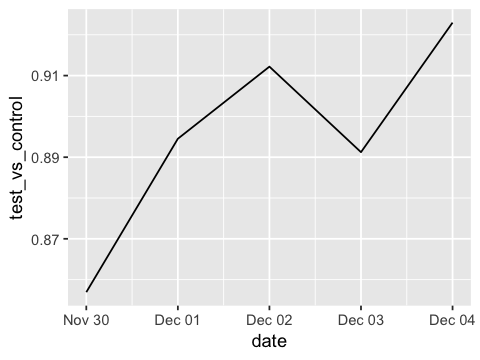

In [14]:
# Plot the test data day by day to see if the pattern constantly happened or just started suddenly
data_test_day_by_day <- data_test %>%
                        group_by(date) %>%
                        summarize(test_vs_control = mean(conversion[test == 1]/ mean(conversion[test == 0])))
ggplot(data_test_day_by_day, aes(x = date, y = test_vs_control)) +
    geom_line()

* As the graph shown above, it shows:
    1. Test has constantly been worse than control and there's relatively little variance across days. That probably means that we do have enough data, but there was some  bias in the experiment set up
    2. On a side note, we just ran it for 5 days. We should always run the test for at least 1 full week to capture weekly patterns, 2 weeks would be much better

* Probably, there's for some reason some segment of users more likely to end up in test or in control, this segment had a significantly above/ below conversion rate and affected the overall results
* In an ideal workld, the distribution of people in test and control for each segment should be the same.
* One way to check: build a decision tree where the variables are the user dimensions and the outcome variable is whether teh user is in test or control. If the tree splits, it means that for given values of that variable you are more likely to end up in test or control.
* The tree should not split or at least not be able to separate the two classes 

In [16]:
# Remove conversion column, and only look at 1% of the population
tree = rpart(test ~., data_test[, -8],
            control = rpart.control(minbucket = nrow(data_test)/100, maxdepth = 2))
tree

n= 401085 

node), split, n, deviance, yval
      * denotes terminal node

1) root 401085 99692.820 0.5379757  
  2) country=Bolivia,Chile,Colombia,Costa Rica,Ecuador,El Salvador,Guatemala,Honduras,Mexico,Nicaragua,Panama,Paraguay,Peru,Venezuela 350218 87553.970 0.4987693 *
  3) country=Argentina,Uruguay 50867  7894.097 0.8079108 *

* The randomization is perfect for the countries on one side of the split (country=Bolivia,Chile,Colombia,Costa Rica,Ecuador,El Salvador,Guatemala,Honduras,Mexico,Nicaragua,Panama,Paraguay,Peru,Venezuela). In that leaf the test/ control ratio is 0.498. However, Argentina and Uruguay together have 80% test and 20% control.
* Let's check the test results after controlling for country.

In [18]:
data_test_country <- data_test %>%
                     group_by(country) %>%
                     summarize(p_value = t.test(conversion[test == 1],conversion[test == 0])$p.value,
                            conversion_test = t.test(conversion[test == 1], conversion[test == 0])$estimate[1],
                            conversion_control = t.test(conversion[test == 1], conversion[test == 0])$estimate[2]) %>%
                     arrange(p_value)
data_test_country

country,p_value,conversion_test,conversion_control
Mexico,0.1655437,0.05118631,0.04949462
El Salvador,0.2481267,0.04794689,0.05355404
Chile,0.3028476,0.05129502,0.04810718
Argentina,0.3351465,0.01372502,0.01507054
Colombia,0.4237191,0.05057096,0.05208949
Honduras,0.4714629,0.04753981,0.05090576
Guatemala,0.5721072,0.04864721,0.05064288
Venezuela,0.5737015,0.04897831,0.05034367
Costa Rica,0.6878764,0.05473764,0.05225564
Panama,0.7053268,0.04937028,0.04679552


* After we control for country, the test clearly appears non significant. Noe a great success given that the goal was to improve conversion rate, but at least we know that a localized translation didn't make things worse!